In [ ]:
#!pip install --upgrade gensim
import gensim
import pandas as pd
import nltk
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
nltk.download('punkt')

In [16]:
import re

# Text for fitting PCA. Realistically, should be corpus of text somewhat related to what we want to sonify. Should probably be a superset of the text we want to sonify. 
# Might be worth looking into results with completely unrelated text as well. 
pca_text="Word embedding is the collective name for a set of language modeling and feature learning techniques in natural language processing where words or phrases from the vocabulary are mapped to vectors of real numbers. Conceptually it involves a mathematical embedding from a space with many dimensions per word to a continuous vector space with a much lower dimension.The use of multi-sense embeddings is known to improve performance in several NLP tasks, such as part-of-speech tagging, semantic relation identification, and semantic relatedness. However, tasks involving named entity recognition and sentiment analysis seem not to benefit from a multiple vector representation."
# Text we want to sonify
son_text = "Between shadow and space, between harnesses and virgins, Endowed with a singular heart and fatal dreams, Impetuously pale, withered in the forehead and in mourning like an angry widower every day of my Life, Oh, for every drink of invisible water I swallow drowsily and with every sound I take in, trembling, I feel the same missing thirst and the same cold fever, an ear being born, an indirect anguish, As if thieves were arriving, or ghosts, And inside a long, deep, hollow shell, Like a humiliated waiter, like a bell gone a bit Hoarse, Like an old mirror, like the smell of an empty house Where the guests come back at night hopelessly drunk, And there’s an odor of clothes thrown on the floor, and An absence of flowers — or maybe somehow a little less melancholic — But the truth is, suddenly, the wind lashing my chest, The infinitely dense nights dropped into my bedroom, The noise of a day burning with sacrifice Demand what there is in me of the prophetic, with Melancholy And there’s a banging of objects that we call without being Answered, And a restless motion, and a muddled name."

def tokenize(text):
    text=re.sub(r"[^.A-Za-z]",' ',text)
    sentence=text.split('.')
    tokens=[nltk.word_tokenize(words) for words in sentence]
    return sentence, tokens

_, pca_tokens = tokenize(pca_text)
son_sentence, son_tokens = tokenize(son_text)
#tokens

In [15]:
filename = './GoogleNews-vectors-negative300.bin' # use your own file path/name
model = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=True)

In [149]:
# Build set of words that exist in vocabulary 
# Words that aren't in vocab will just be ignored for the time being. 
def get_tokens(model, tokens):
    viable_vocab_list = set()
    for i in range(len(tokens)):
        for j in range(len(tokens[i])):
            try:
                if tokens[i][j] in model.wv.key_to_index:
                    viable_vocab_list.add(tokens[i][j])
            except:
                if tokens[i][j] in model.key_to_index:
                    viable_vocab_list.add(tokens[i][j])
    return viable_vocab_list

viable_vocab = get_tokens(model, pca_tokens)

In [42]:
# Embedding representations of words to build PCA. 
values = model[list(viable_vocab)]

0 0
5 0.12851179929641388
10 0.19893635810361912
15 0.25036078519401844
20 0.2919902627438756
25 0.32650963156116314
30 0.35755835229460653
35 0.3857024319834565
40 0.41120971864814143
45 0.4349336213721738
50 0.45716633324795025
55 0.4779831495975279
60 0.4978497484000764
65 0.5167376964702352
70 0.5347124310827724
75 0.5519061933505157
80 0.5683189078917232
85 0.5840678423130882
90 0.5993271392070808
95 0.6140507699436928
100 0.6283076568571498


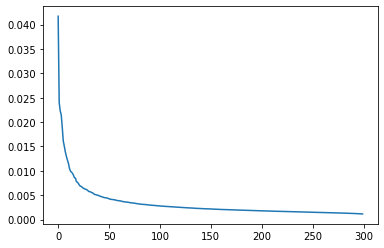

In [140]:
# just testing. 
def peek_dimensionality(model, values):
    pca = PCA() # full dimensionality
    try:
        pca.fit(model[values])
    except: 
        pca.fit(model.wv[values])
    
    # How many dimensions should we keep? 
    plt.plot(pca.explained_variance_ratio_)
    for i in range(0,101,5):
        print(i, sum(pca.explained_variance_ratio_[:i]))
    
    return pca, pca.explained_variance_ratio_

pca, variances = peek_dimensionality(model, model.index_to_key)

# that's a lot of variance left unexplained, but note that much of it with be irrelevant for our prose.
# what if we only fit pca to a much smaller poetry dataset? 

In [94]:
# from https://www.kaggle.com/danofer/poetry2vec-word-embeddings
df = pd.read_csv("../Gutenberg-Poetry.csv",
                 usecols=["s"]).drop_duplicates().rename(columns={"s":"text"})
df = df.loc[df["text"].str.split().str.len()>1]

In [117]:
from gensim.utils import simple_preprocess
df['text'] = df['text'].apply(lambda x: simple_preprocess(x, True, 2, 420))
sentences = df['text']

In [150]:
poetry_vocab = set()
for sentence in sentences: 
    for item in sentence:
        poetry_vocab.add(item)

In [151]:
poetry_tokens = get_tokens(model, [list(poetry_vocab)])
print(len(poetry_tokens), len(poetry_vocab))

60266 234066


0 0
5 0.11249178275465965
10 0.17350723315030336
15 0.22103842347860336
20 0.26129768742248416
25 0.29616960091516376
30 0.3274519839324057
35 0.35585123347118497
40 0.3818652369081974
45 0.40594088891521096
50 0.4285931712947786
55 0.45011959644034505
60 0.470502657815814
65 0.48989265877753496
70 0.5084733248222619
75 0.5263335250783712
80 0.5435003598686308
85 0.560002873186022
90 0.5758612812496722
95 0.59125537564978
100 0.6062172821257263


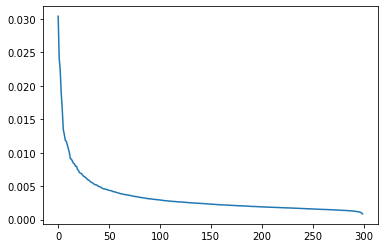

In [152]:
# Does the subspace act nicer if we only look at poetry? 
pca, variances = peek_dimensionality(model, poetry_tokens) 
# This appears even worse. 

In [205]:
#model_poetry = gensim.models.Word2Vec(sentences, vector_size = 200, workers = 8)
#word_vectors = model_poetry.wv
#word_vectors.save('model_poetry.wordvectors')
model = gensim.models.KeyedVectors.load('model_poetry.wordvectors', mmap = 'r')

In [210]:
len(model.key_to_index)

65613

0 0
5 0.27524219699707475
10 0.41559634749398705
15 0.5119611630619784
20 0.5774398350672436
25 0.6264993415188278
30 0.6654079570623571
35 0.6996309169992612
40 0.7285603922072524
45 0.7533432201897233
50 0.775435574027563
55 0.7952599955758325
60 0.8130683776292431
65 0.8291618454162101
70 0.8436943402394049
75 0.8570990944321724
80 0.8692733772561188
85 0.8805999129939731
90 0.8908990249394673
95 0.9006459515985323
100 0.9097951315675008


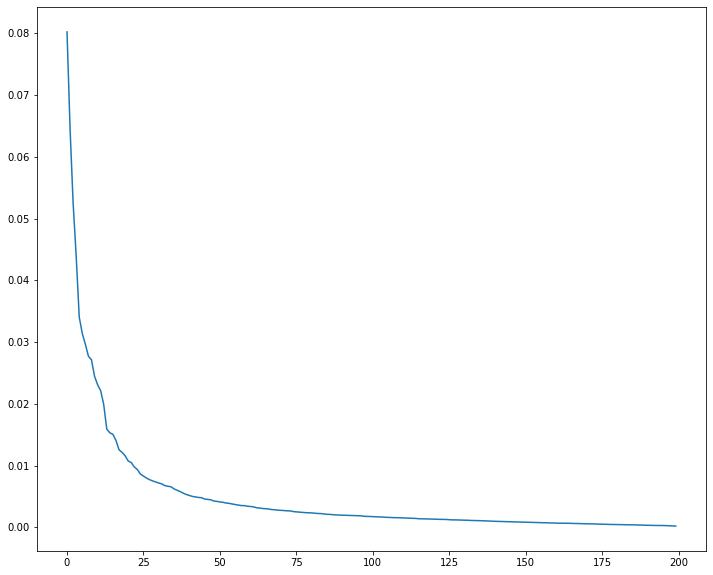

In [211]:
_, _ = peek_dimensionality(model, get_tokens(model, [list(poetry_vocab)]))

In [214]:
num_components = 10 # playing around with components
pca = PCA(n_components=num_components)

# Fit PCA with sample corpus. We *could* do this with the entire vocab list rather than
# the sample text, but unsure if that's a good idea. 
pca.fit(model[model.index_to_key])
#sum(pca.explained_variance_ratio_[:10])

PCA(n_components=10)

In [215]:
#pca.n_components_
sum(pca.explained_variance_ratio_[:100])

0.41562396415650366

In [216]:
#values_pca = pca.transform(values)
values_pca = pca.transform(model[model.index_to_key][:200])

# Plot first 2 components of text used to generate pca fit
neww_X = values_pca[:, :2]

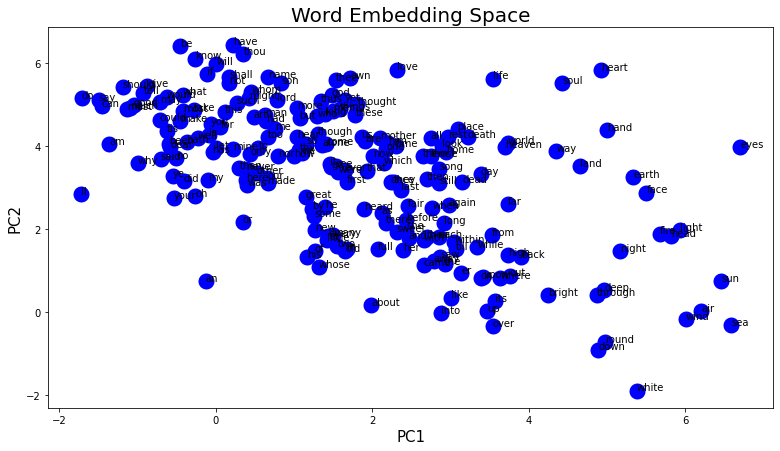

In [217]:
def plot_pca(neww_X, viable_vocab):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(13,7))
    plt.scatter(neww_X[:,0],neww_X[:,1],linewidths=10,color='blue')
    plt.xlabel("PC1",size=15)
    plt.ylabel("PC2",size=15)
    plt.title("Word Embedding Space",size=20)
    vocab=list(viable_vocab)
    for i, word in enumerate(vocab):
      plt.annotate(word,xy=(neww_X[i,0],neww_X[i,1]))
#plot_pca(neww_X, viable_vocab)
plot_pca(neww_X, model.index_to_key[:200])

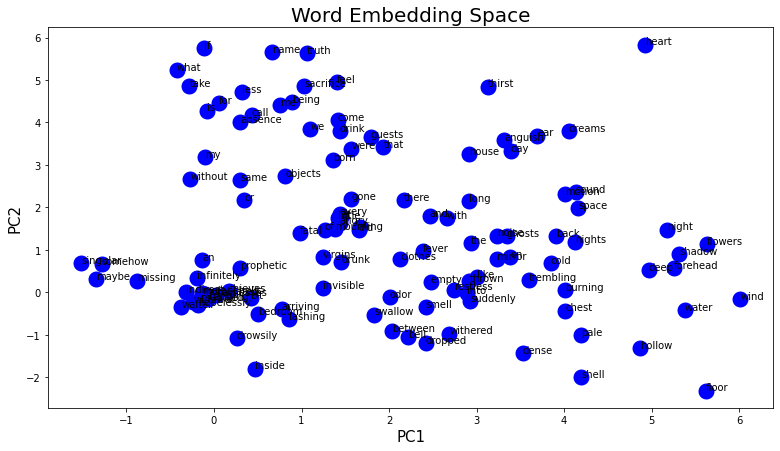

In [218]:
# Generate PCA representations of text we'd like to sonify.
son_viable_vocab = get_tokens(model, son_tokens)
son_values = model[list(son_viable_vocab)]
son_values_pca = pca.transform(son_values)
son_X = son_values_pca[:, :2]
plot_pca(son_X, son_viable_vocab)

# Seems like a pretty poor representation in this example, which is pretty expected since the pca was fit on
# a small & unrelated sample of text

In [219]:
son_dict = {}
for i, word in enumerate(list(son_viable_vocab)): 
    son_dict[word] = son_values_pca[i]

In [220]:
son_dict['shadow']

array([ 5.3115897 ,  0.89810705, -1.7371128 ,  0.11075967,  1.4803194 ,
       -0.44506228,  0.35988137,  1.6907429 , -1.0562896 , -1.8879967 ],
      dtype=float32)

In [221]:
sonify_list = []
for word in son_tokens[0]: 
    try: 
        sonify_list.append(son_dict[word])
    except:
        # do we want a filler or just move on to the next word?
        continue

In [174]:
import sys

sys.path.append('./modules/')

import matplotlib.pyplot as plt
from importlib import reload
import subprocess as sp
from subprocess import Popen
import os

import notepicker
import writeCmixSco_GRAN_v2 as wRT_gran
import writeCmixSco_WT_ac as wRT_wt
# _ac stands for autocheck

%matplotlib inline

# ======================================================
# autocheck for your RTcmix installation type: 
cmixStatus, cmixResult = sp.getstatusoutput("CMIX")
if cmixStatus == 0:
    cmixInstalled = True
    print("CMIX found.")
else:
    cmixInstalled = False
    print("CMIX not found, using pyGoRTcmix instead.")
# ======================================================

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 10]

CMIX not found, using pyGoRTcmix instead.


In [185]:
n_octaves_total = 5
root_note  = 110.0
ints_per_oct = 12

# chromatic scale of n octaves: 
intervals = np.linspace(0,n_octaves_total,int(n_octaves_total*ints_per_oct))
pitches = root_note*(2**intervals)
print(pitches)

[ 110.          116.65509233  123.71282333  131.19755298  139.13511505
  147.5529063   156.47998098  165.94715117  175.9870931   186.63445995
  197.92600143  209.90069064  222.59985861  236.06733689  250.34960892
  265.49597039  281.55869944  298.59323708  316.65837855  335.81647624
  356.13365492  377.68003996  400.52999938  424.76240053  450.46088229
  477.71414376  506.61625043  537.26695881  569.77206077  604.24374868
  640.80100265  679.57000117  720.68455663  764.28657722  810.52655664
  859.56409363  911.56844277  966.71909868 1025.20641557 1087.23226422
 1153.01072877 1222.76884564 1296.74738713 1375.20169248 1458.40254915
 1546.63712748 1640.20997186 1739.44405187 1844.68187701 1956.2866789
 2074.64366498 2200.16134807 2333.27295633 2474.43792862 2624.14350022
 2782.90638455 2951.27455665 3129.82914448 3319.18643474 3520.        ]


In [186]:
time_line = np.linspace(0,len(sonify_list), len(sonify_list))
times = [] 
for x in time_line: 
    for i in range(num_components):
        times.append(x)

In [187]:
notes = [] 
counter = 0
ranges = []

for i in range(num_components):
    values = [x[i] for x in sonify_list]
    ranges.append((min(values), max(values)))

print(ranges)

for i, x in enumerate(times):
    a = i%num_components
    b = i//num_components
    target = sonify_list[b][a]
    
    target_scaled = (target-ranges[a][0])/(ranges[a][1]-ranges[a][0])
    notes.append(target_scaled*2000)

[(-1.5195414, 6.0119433), (-2.317111, 5.8345437), (-4.0547385, 4.6612725), (-2.6844363, 5.4095635), (-2.8312187, 3.859403), (-4.4977007, 3.1954417), (-3.9642236, 1.4786276), (-2.669326, 3.8572156), (-4.4615626, 4.516145), (-4.1324935, 2.7123299)]


In [193]:
# (4) write RTcmix Wavetable score
reload(wRT_wt)
base_name = 'test_iter2'
trim = -1
tones_dict = {}
# tones_dict['times'] = np.asarray(times[:trim])
tones_dict['times'] = times
# tones_dict['notes'] = np.asarray(notes[:trim])
# tones_dict['durs'] = np.asarray(durs[:trim]) 

# tones_dict['times'] = np.ones(len(notes[:trim]))
tones_dict['notes'] = notes
tones_dict['durs'] = np.ones(len(times))
tones_dict['amps'] = np.ones(len(times))*2000
tones_dict['pans'] = np.ones(len(times))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

test_iter2.sco
CMIX not found; rtoutput() will not be used in score.


In [ ]:
dur_sound = max(times)

if cmixInstalled:
    cmix_cmd = 'CMIX < ' + base_name + '.sco'
    print(cmix_cmd)
else:
    dur = str(dur_sound)
    cmix_cmd = os.path.abspath('/Users/calvinlu/Documents/sonification/pyGoRTcmix/Contents/MacOS/pyGoRTcmix') + ' -inputscore ' + os.path.abspath(base_name + '.sco') + ' -output ' + os.path.abspath(base_name + '.wav') + ' -dur ' + dur
    print(cmix_cmd)

# the ! tells the notebook to run a command in the terminal
if sys.platform == 'win32':
    ! dir *.sco
else:
    ! ls *.sco

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
# runCMIX.wait()
print("\n" + "hopefully i just wrote your sound file; is it here?" + "\n")
if sys.platform == 'win32':
    ! dir *.wav
else:
    ! ls *.wav

#sp.run(['mv', score_name, '../3_output_nogit'])
#sp.run('mv *.wav ../3_output_nogit/', shell=True)

In [ ]:
#### 
# https://towardsdatascience.com/visualization-of-word-embedding-vectors-using-gensim-and-pca-8f592a5d3354
# Unsure why anyone is bothering with doing this manually...
####

'''
# Get list of words in vocab
words=list(model.wv.vocab)
#print(words)

# Get vector representations of all words 
X=model[model.wv.vocab]
df=pd.DataFrame(X) # (X?)
df.shape
df.head()

#Computing the correlation matrix
X_corr=df.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(X_corr)

#Sorting the eigen vectors coresponding to eigen values in descending order
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]

#Projecting it onto new dimesion with 2 axis
neww_X=np.dot(X,new_vectors)
'''

'\n# Get list of words in vocab\nwords=list(model.wv.vocab)\n#print(words)\n\n# Get vector representations of all words \nX=model[model.wv.vocab]\ndf=pd.DataFrame(X) # (X?)\ndf.shape\ndf.head()\n\n#Computing the correlation matrix\nX_corr=df.corr()\n\n#Computing eigen values and eigen vectors\nvalues,vectors=np.linalg.eig(X_corr)\n\n#Sorting the eigen vectors coresponding to eigen values in descending order\nargs = (-values).argsort()\nvalues = vectors[args]\nvectors = vectors[:, args]\n\n#Taking first 2 components which explain maximum variance for projecting\nnew_vectors=vectors[:,:2]\n\n#Projecting it onto new dimesion with 2 axis\nneww_X=np.dot(X,new_vectors)\n'